# Week 1: Gradient Descent

**Group:** CCTS<br>

**Members**:
   + Chiara Maccani (2027591)
   + Samuele Piccinelli (2027650)
   + Tommaso Stentella (2027586)
   + Cristina Venturini (2022461)

# 1. Visualising the surface

We will consider two convex functions of the form:
$$z(x,y) = 1 + \frac{1}{2}q_1(x^2+y^2)-\cos[2\pi(xy-y^2)]$$
and
$$z(x,y) = b(1-e^{-\frac{1}{2}w(x^2+y^2)})+\frac{1}{2}q_2(-x^3+y)^2 $$

with $q_1 = 6$, $q_2 = \frac{1}{10}$, $b=20$ and $w = 10$.

These surfaces can be plotted using the cells below. 

In [1]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LogNorm

plt.rc('font', family='serif', size=8)
plt.rc('mathtext', fontset='cm')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=20)
plt.rc('figure', titlesize=15)

import numpy as np

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="jet", alpha=1): #cmap="RdYlBu_r"

    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap, 'alpha':alpha,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, 50)
      
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;

    
def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=1):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color=color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color=color, marker='.', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

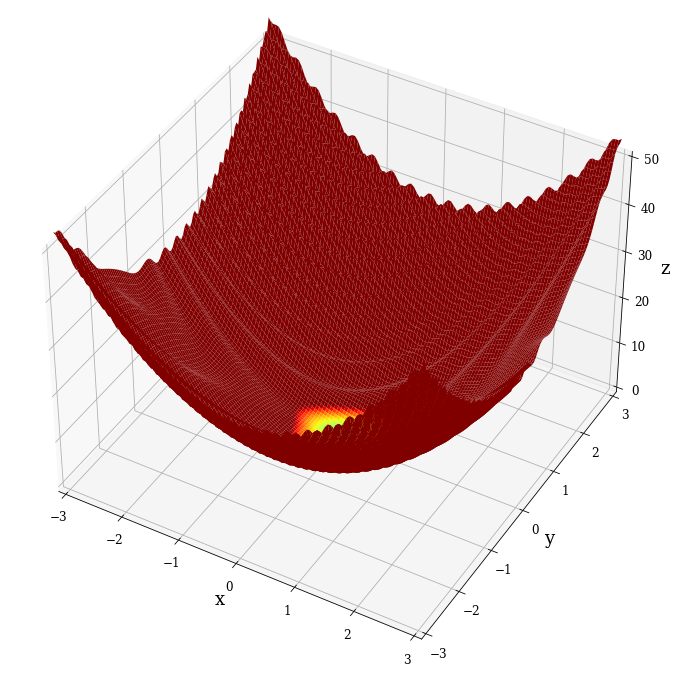

In [2]:
def func_2(x,y,q=6):
    return 1+0.5*q*(x**2+y**2)-np.cos(2*np.pi*(x*y-y**2))

def grad_func_2(params,q=6):
    x=params[:,0]
    y=params[:,1]
    grad_x=q*x+2*np.pi*y*np.sin(2*np.pi*(x*y-y**2))
    grad_y=q*y+2*np.pi*(x-2*y)*np.sin(2*np.pi*(x*y-y**2))
    return [grad_x,grad_y]

plt.close()
warnings.filterwarnings('ignore')

x, y = np.mgrid[-3:3:121j, -3:3:121j]
fig1,ax1=plot_surface(x,y,func_2(x,y))
plt.show()

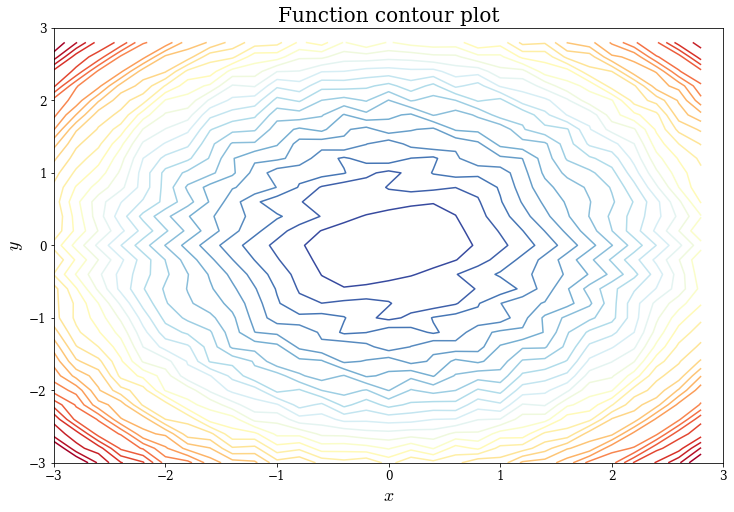

In [3]:
def contour_func_2():
    x, y = np.meshgrid(np.arange(-3., 3., 0.2), np.arange(-3., 3., 0.2))
    fig, ax = plt.subplots(figsize=(12, 8))
    z=func_2(x,y)
    cax = ax.contour(x, y, z, levels=np.linspace(0, 50, 30), cmap="RdYlBu_r")

    ax.set_xlabel('$x$', size=18)
    ax.set_ylabel('$y$', size=18)

    ax.set_xlim((-3., 3.))
    ax.set_ylim((-3., 3.))
    
    return fig,ax

fig2,ax2 = contour_func_2()
ax2.set_title('Function contour plot')
plt.show()

# 2. Defining the optimisation algorithms

We modified the functions to optimize nested loops in `numpy` to use broadcasting and perform operations in a vectorized way: the variable `param_traj` becomes a $3$-D matrix of dimensions $(N_{epoch}+1, N_{points}, 2)$ where $N_{epoch}$ is the number of iterations, $N_{points}$ the number of points in the grid, $2$ is the number of coordinates $(x,y)$.

In this way we apply the algorithm in one take for every initial condition $(x_i,y_i)$ and then iterate over all time instants. For this task the variable `n_points` is introduced and the dimension of the variables in play are modified accordingly.

In [4]:
def gd(grad, init, n_points, n_epochs=1000, eta=10**-4, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1, n_points, 2])
    param_traj[0,:,:]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.standard_normal(np.shape(params))
        v=eta*(np.array(grad(params)).T+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def gd_with_mom(grad, init, n_points, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1, n_points, 2])
    param_traj[0,:,:]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.standard_normal(np.shape(params))
        v=gamma*v+eta*(np.array(grad(params)).T+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_points, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1, n_points, 2])
    param_traj[0,:,:]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.standard_normal(np.shape(params))
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov)).T+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def rms_prop(grad, init, n_points, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1, n_points, 2])
    param_traj[0,:,:]=init
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.standard_normal(np.shape(params))
        g=np.array(grad(params)).T+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                                            
def adams(grad, init, n_points, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1, n_points, 2])
    param_traj[0,:,:]=init
    v=0
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.standard_normal(np.shape(params))
        g=np.array(grad(params)).T+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

# 3. Finding the optimal learning rate $\eta$

In order to show a quantitative statistical comparison of the performance of different algorithms we computed the average value of the function over the different initial values for each iteration.

We used two different values of $\eta$, one for GD, GDM and NAG, which we called $\eta_s$, and one for RMS_prop and ADAM, which we called $\eta_l$. <br>
To find the optimal value of $\eta$ we plotted the average value of the function vs number of epochs for different values of $\eta$. 

## 3.1 Finding $\eta_s$

In [5]:
epoch_e = 10**4

n_coord_e = 30
n_points_e = n_coord_e**2

x_e, y_e = np.meshgrid(np.linspace(-3, 3, n_coord_e), np.linspace(-3, 3, n_coord_e))

In [6]:
def eta_s(x_e, y_e, n_points_e, epoch_e, eta):
    gd_trajectory = gd(grad_func_2, np.array([x_e.flatten(),y_e.flatten()]).T, n_points_e, epoch_e, eta=eta, noise_strength=0)
    z_gd = np.array([func_2(gd_trajectory[i,:,0], gd_trajectory[i,:,1]) for i in range(epoch_e+1)])
    return np.mean(z_gd, axis=1)

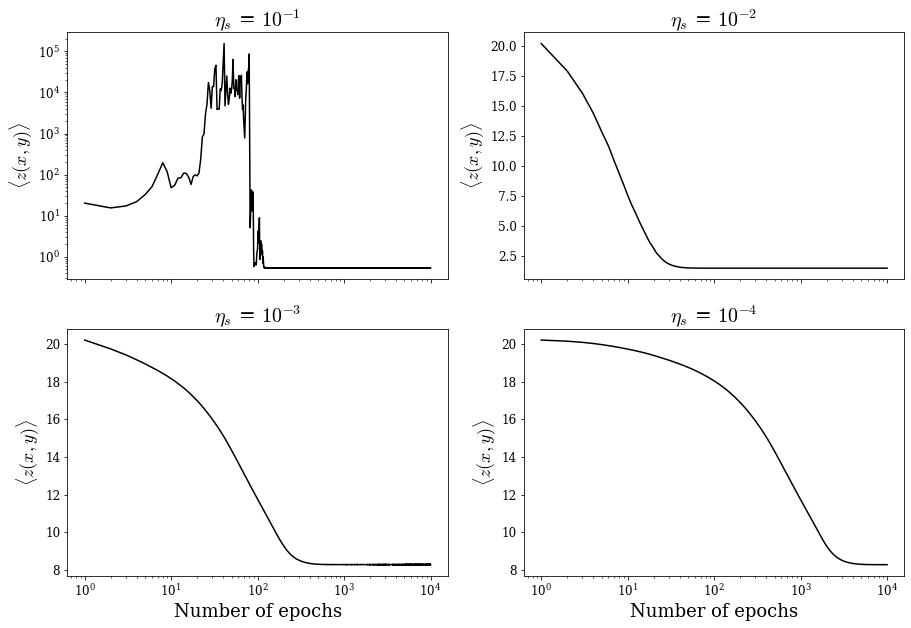

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharex=True)

ax1.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 10**-1), color='k')
ax2.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 10**-2), color='k')
ax3.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 10**-3), color='k')
ax4.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 10**-4), color='k')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_title('$\eta_s$ = $10^{-1}$')
ax2.set_title('$\eta_s$ = $10^{-2}$')
ax3.set_title('$\eta_s$ = $10^{-3}$')
ax4.set_title('$\eta_s$ = $10^{-4}$')

ax3.set_xlabel("Number of epochs", size=18)
ax4.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax2.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax3.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax4.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)

plt.show()

As one can see the only value which allows to reach the minimum is $\eta_s = 10^{-1}$; still, it shows relevant instabilities and could be too big for GDM. Because of this we eventually chose $\eta_s = 10^{-2}$, since both $10^{-3}$ and $10^{-4}$ stop at $z\gg 0$.

## 3.2 Finding $\eta_l$

In [8]:
def eta_l(x_e, y_e, n_points_e, epoch_e, eta):
    rms_prop_trajectory = rms_prop(grad_func_2, np.array([x_e.flatten(),y_e.flatten()]).T, n_points_e, epoch_e, eta=eta, beta=0.9, epsilon=10**-8, noise_strength=0)
    z_rms_prop = np.array([func_2(rms_prop_trajectory[i,:,0], rms_prop_trajectory[i,:,1]) for i in range(epoch_e+1)])
    return np.mean(z_rms_prop, axis=1)

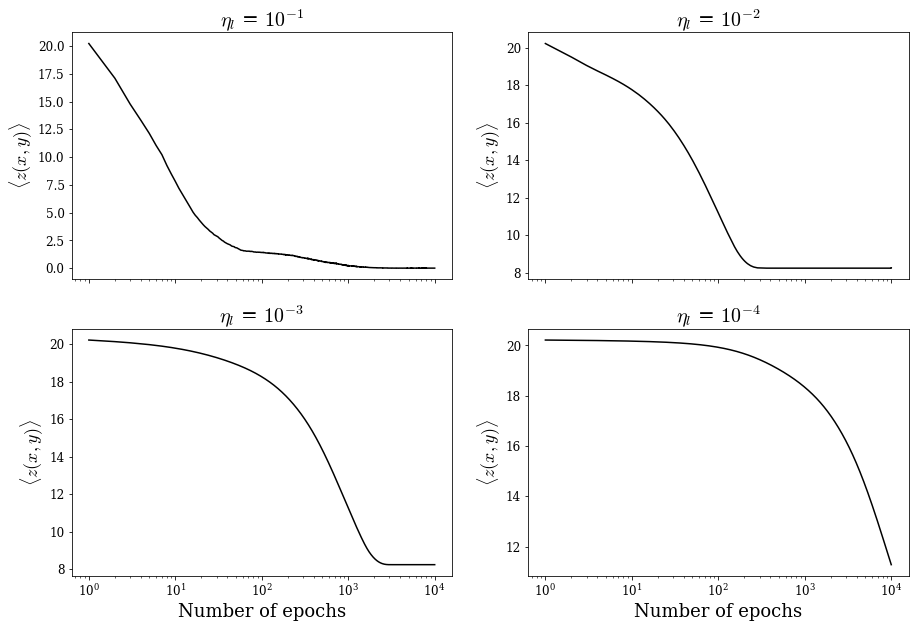

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharex=True)

ax1.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-1), color='k')
ax2.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-2), color='k')
ax3.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-3), color='k')
ax4.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-4), color='k')
ax1.set_xscale('log')


ax1.set_title('$\eta_l$ = $10^{-1}$')
ax2.set_title('$\eta_l$ = $10^{-2}$')
ax3.set_title('$\eta_l$ = $10^{-3}$')
ax4.set_title('$\eta_l$ = $10^{-4}$')

ax3.set_xlabel("Number of epochs", size=18)
ax4.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax2.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax3.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax4.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)

plt.show()

By looking at the graphs above, $\eta_l = 10^{-1}$ is the only value which allows to reach $0$; because of this, we chose $\eta_l = 10^{-1}$ for the following analysis.

# 4. Comparison results

In [10]:
epoch=5*10**3
lr_l=10**-1
lr_s=10**-2

n_coord = 30
n_points = n_coord**2

x, y = np.meshgrid(np.linspace(-3, 3, n_coord), np.linspace(-3, 3, n_coord))

In [11]:
gd_trajectory = gd(grad_func_2, np.array([x.flatten(), y.flatten()]).T, n_points, epoch, eta=lr_s, noise_strength=0)
z_gd = np.array([func_2(gd_trajectory[i,:,0], gd_trajectory[i,:,1]) for i in range(epoch+1)])
avg_gd = np.mean(z_gd, axis=1)

gdm_trajectory = gd_with_mom(grad_func_2, np.array([x.flatten(), y.flatten()]).T, n_points, epoch, eta=lr_s, gamma=0.9, noise_strength=0)
z_gdm = np.array([func_2(gdm_trajectory[i,:,0], gdm_trajectory[i,:,1]) for i in range(epoch+1)])
avg_gdm = np.mean(z_gdm, axis=1)

NAG_trajectory = NAG(grad_func_2, np.array([x.flatten(), y.flatten()]).T, n_points, epoch, eta=lr_s, gamma=0.9, noise_strength=0)
z_NAG = np.array([func_2(NAG_trajectory[i,:,0], NAG_trajectory[i,:,1]) for i in range(epoch+1)])
avg_NAG = np.mean(z_NAG, axis=1)

rms_prop_trajectory = rms_prop(grad_func_2, np.array([x.flatten(),y.flatten()]).T, n_points, epoch, eta=lr_l, beta=0.9, epsilon=10**-8, noise_strength=0)
z_rms_prop = np.array([func_2(rms_prop_trajectory[i,:,0], rms_prop_trajectory[i,:,1]) for i in range(epoch+1)])
avg_rms_prop = np.mean(z_rms_prop, axis=1)

adam_trajectory = adams(grad_func_2, np.array([x.flatten(),y.flatten()]).T, n_points, epoch, eta=5*10**-1, gamma=0.9, beta=0.99, epsilon=10**-8, noise_strength=0)
z_adam = np.array([func_2(adam_trajectory[i,:,0], adam_trajectory[i,:,1]) for i in range(epoch+1)])
avg_adam = np.mean(z_adam, axis=1)

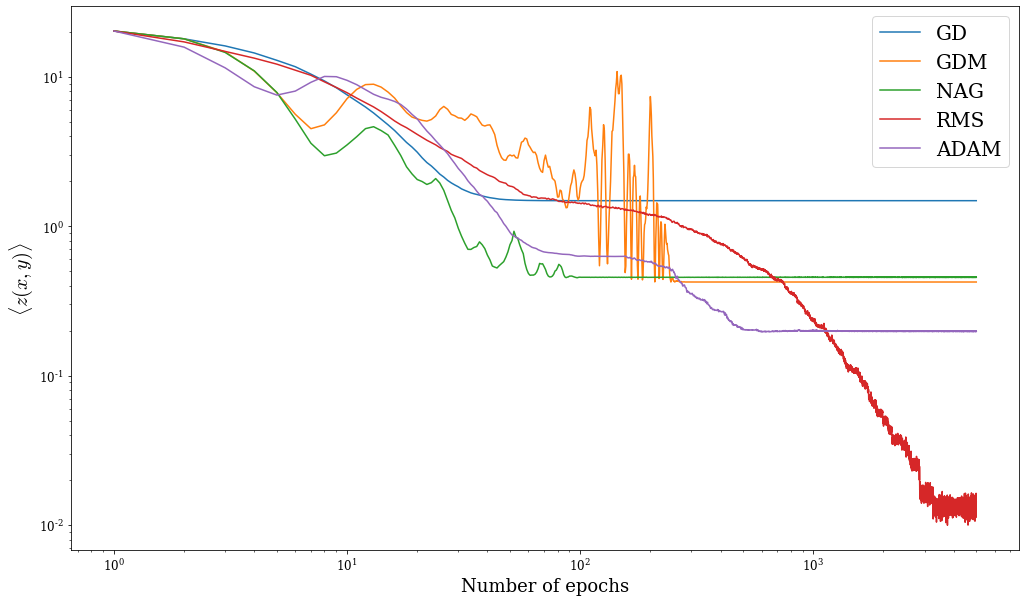

In [12]:
fig, ax = plt.subplots(figsize=(17, 10))

ax.plot(np.linspace(1, epoch+1, epoch+1), avg_gd, label='GD')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_gdm, label='GDM')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_NAG, label='NAG')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_rms_prop, label='RMS')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_adam, label='ADAM')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Number of epochs", size=18)
ax.set_ylabel(r"$\langle z(x,y) \rangle$", size=20)
ax.legend(prop={'size': 20})
plt.show()

By looking at the graph, the best performing algorithm appears to be RMS_prop, which presents some oscillations but in a small range and actually reaches the minimum. One can also see that ADAM performs poorer than RMS_prop and reaches an average value of $\sim0.2$; actually, as we'll show below for an example, the trajectory keeps oscillating around a certain value.

At the beginning the learning rate was set at the same value for all the second moment algorithms but we noticed that ADAM didn't perform as well as expected and so we increased its learning rate to $0.5$. By doing so its performance improved significantly. 

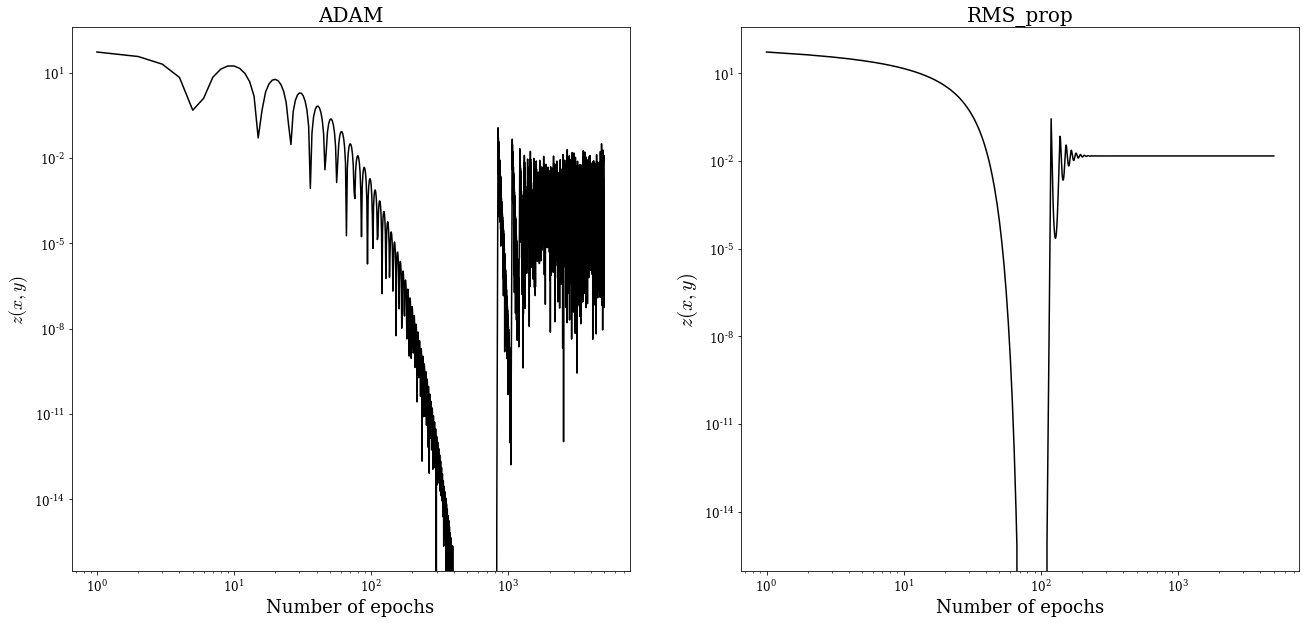

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(np.linspace(1, epoch+1, epoch+1), z_adam[:,0], color='k', label='ADAM')
ax1.set_title('ADAM')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel(r"$z(x,y)$", size=18)

ax2.plot(np.linspace(1, epoch+1, epoch+1), z_rms_prop[:,0], color='k', label='ADAM')
ax2.set_title('RMS_prop')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel(r"$z(x,y)$", size=20)

plt.show()

The comparison between the $2$ methods shows how the RMS_prop algorithm is much more stable with respect to the found minimum.

We show below $2$ trajectories obtained through the ADAM algorithm, one of which doesn't reach the global minimum (in black) but stabilizes around a local minimum.

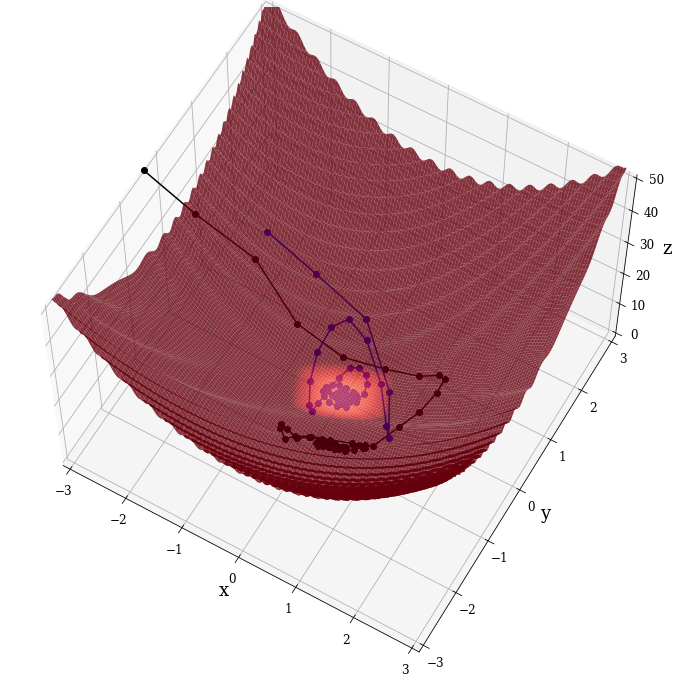

In [15]:
x, y = np.meshgrid(np.linspace(-3, 3, 131), np.linspace(-3, 3, 131))

fig1,ax1=plot_surface(x,y,func_2(x,y), azim=-60, elev=60, dist=10, cmap='Reds', alpha=0.8)
ax1.plot(adam_trajectory[:,360,0], adam_trajectory[:,360,1], z_adam[:,0], color='k', marker='o')
ax1.plot(adam_trajectory[:,370,0], adam_trajectory[:,370,1], z_adam[:,0], color='b', marker='o')
plt.show()

# 5. Optional 

In this section we test the ADAM algorithm on a simple function in order to show how it can become unstable with respect to a minimum that was reached at some earlier iteration. The chosen non-convex function is of the following form:
$$z(x, y) = 2A + (x^2 + y^2) - A(\cos(2\pi x) + \cos(2\pi y))$$
with $A = 10$.

In [16]:
def adam_unstable(x,y):
    return 20 + x**2 + y**2 - 10*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))

def grad_adam_unstable(params):
    x=params[0]
    y=params[1]
    grad_x=2*x+10*np.sin(2*np.pi*x)*2*np.pi
    grad_y=2*y+10*np.sin(2*np.pi*y)*2*np.pi
    return [grad_x,grad_y]

def adams_scalar(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

In [17]:
epoch_unst = int(3e4)
adam_unst = adams_scalar(grad_adam_unstable, np.array([0.5,0.5]), epoch_unst, eta=0.5, gamma=0.9, beta=0.999, epsilon=10**-8, noise_strength=0)
z_adam_unst = np.array([adam_unstable(adam_unst[i,0], adam_unst[i,1]) for i in range(epoch_unst+1)])
dist = np.sqrt(adam_unst[:,0]**2 + adam_unst[:,1]**2)

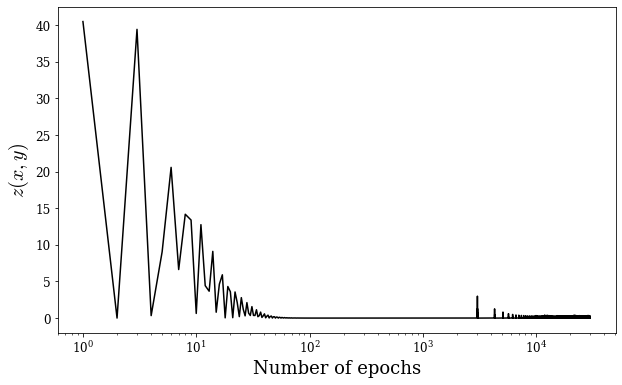

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.linspace(1, epoch_unst+1, epoch_unst+1), z_adam_unst, color='k')
ax.set_xscale('log')
ax.set_xlabel("Number of epochs", size=18)
ax.set_ylabel(r"$z(x,y)$", size=20)
plt.show()

Above the trajectory starting from the point $(0.5, 0.5)$ is shown. The global minimum of the function is $0$ and is first reached at an early stage; nevertheless the trajectory bounces in and out of the global minimum until it stabilizes around the $100$-th iteration, a behaviour due to the setted high value for the learning rate. <br>
However, after $3\times 10^3$ iterations it starts oscillating again, showing further instability.

As a further visual proof, we plot the trajectory covered over the surface by the algorithm below.

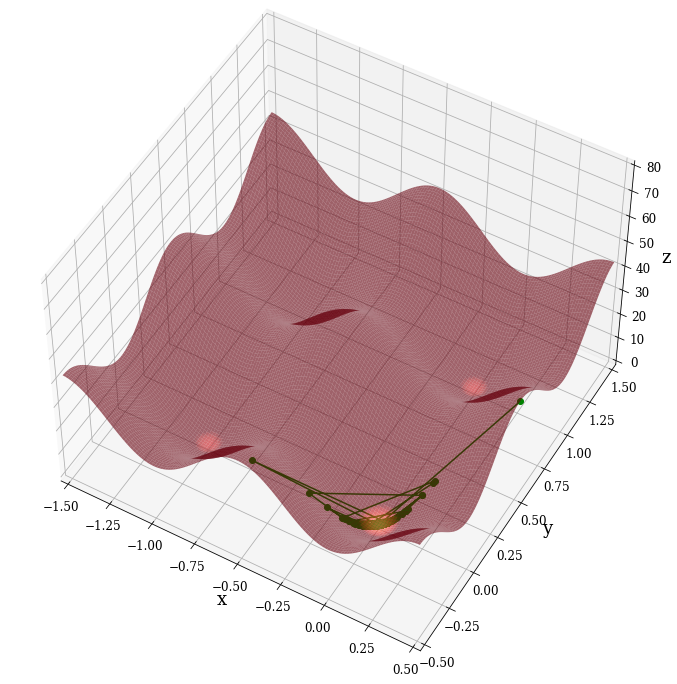

In [19]:
x, y = np.meshgrid(np.linspace(-1.5, 0.5, 131), np.linspace(-0.5, 1.5, 131))

fig1,ax1=plot_surface(x,y,adam_unstable(x,y), azim=-60, elev=50, dist=10, cmap='Reds', alpha=0.6)
ax1.set_xlim(-1.5, 0.5)
ax1.set_ylim(-0.5, 1.5)
ax1.set_zlim(0, 80)
ax1.plot(adam_unst[:,0], adam_unst[:,1], z_adam_unst, color='green', marker='o')

plt.show()

# Second Function

We repeated the whole analysis also for the second function, which is: 
$$z(x,y) = b(1-e^{-\frac{1}{2}w(x^2+y^2)})+\frac{1}{2}q_2(-x^3+y)^2 $$

with $q_2 = \frac{1}{10}$, $b=20$ and $w = 10$.

In [20]:
def func_1(x,y,w=10, q=0.1, b=20):
    return b*(1-np.exp(-0.5*w*(x**2+y**2)))+0.5*q*(-x**3+y)**2

def grad_func_1(params, w=10, q=0.1, b=20):
    x=params[:,0]
    y=params[:,1]
    grad_x = b*np.exp(-0.5*w*(x**2+y**2))*w*x - 3*q*x**2*(-x**3+y)
    grad_y = b*np.exp(-0.5*w*(x**2+y**2))*w*x + q*(-x**3+y)
    return [grad_x,grad_y]

def contour_func_1(ax):
    x, y = np.meshgrid(np.arange(-3., 3., 0.2), np.arange(-3., 3., 0.2))
    z=func_1(x,y)
    cax = ax.contour(x, y, z, levels=np.linspace(0, 40, 80), cmap="RdYlBu_r")

    ax.set_xlabel('$x$', size=18)
    ax.set_ylabel('$y$', size=18)

    ax.set_xlim((-3., 3.))
    ax.set_ylim((-3., 3.))
    
    return ax
    

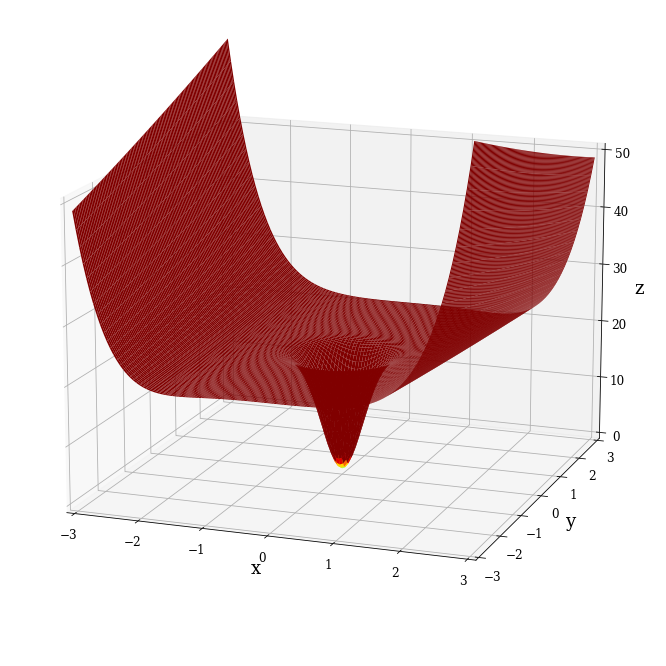

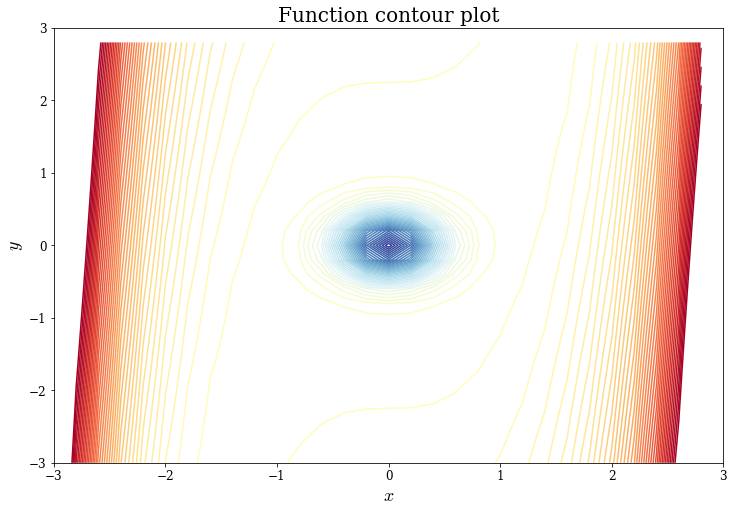

In [21]:
plt.close()
x, y = np.mgrid[-3:3:121j, -3:3:121j]
fig1,ax1=plot_surface(x,y,func_1(x,y), azim=-70, elev=15)

fig2, ax2 = plt.subplots(figsize=(12,8))
ax2 = contour_func_1(ax2)
ax2.set_title('Function contour plot')
plt.show()

## Finding $\eta_s$

In [22]:
epoch_e = 10**4

n_coord_e = 20
n_points_e = n_coord_e**2

x_e, y_e = np.meshgrid(np.linspace(-3, 3, n_coord_e), np.linspace(-3, 3, n_coord_e))

In [23]:
def eta_s(x_e, y_e, n_points_e, epoch_e, eta):
    gd_trajectory = gd(grad_func_1, np.array([x_e.flatten(),y_e.flatten()]).T, n_points_e, epoch_e, eta=eta, noise_strength=0)
    z_gd = np.array([func_1(gd_trajectory[i,:,0], gd_trajectory[i,:,1]) for i in range(epoch_e+1)])
    return np.mean(z_gd, axis=1)

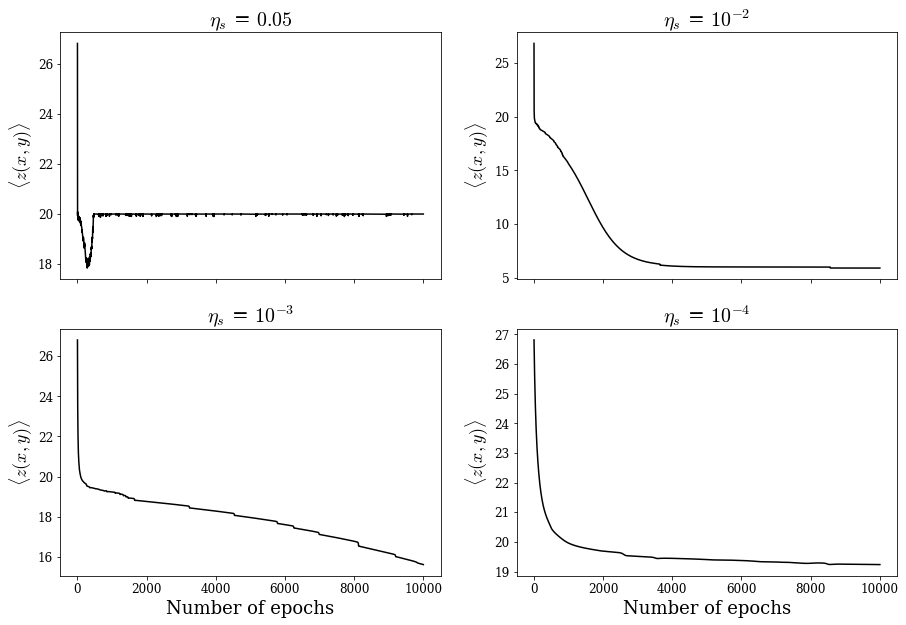

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharex=True)

ax1.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 0.05), color='k')
ax2.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 10**-2), color='k')
ax3.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 10**-3), color='k')
ax4.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_s(x_e, y_e, n_points_e, epoch_e, 10**-4), color='k')

ax1.set_title('$\eta_s$ = $0.05$')
ax2.set_title('$\eta_s$ = $10^{-2}$')
ax3.set_title('$\eta_s$ = $10^{-3}$')
ax4.set_title('$\eta_s$ = $10^{-4}$')

ax3.set_xlabel("Number of epochs", size=18)
ax4.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax2.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax3.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax4.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)

plt.show()

We decided for $\eta_s = 10^{-2}$ with similar considerations as seen above.

## Finding $\eta_l$

In [25]:
def eta_l(x_e, y_e, n_points_e, epoch_e, eta):
    rms_prop_trajectory = rms_prop(grad_func_1, np.array([x_e.flatten(),y_e.flatten()]).T, n_points_e, epoch_e, eta=eta, beta=0.9, epsilon=10**-8, noise_strength=0)
    z_rms_prop = np.array([func_1(rms_prop_trajectory[i,:,0], rms_prop_trajectory[i,:,1]) for i in range(epoch_e+1)])
    return np.mean(z_rms_prop, axis=1)

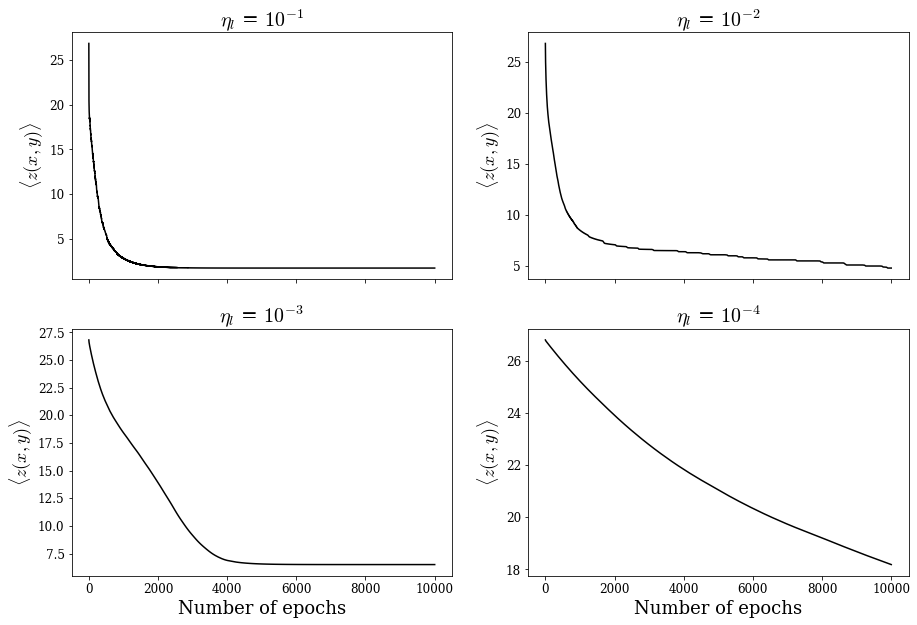

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharex=True)

ax1.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-1), color='k')
ax2.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-2), color='k')
ax3.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-3), color='k')
ax4.plot(np.linspace(1, epoch_e+1, epoch_e+1), eta_l(x_e, y_e, n_points_e, epoch_e, 10**-4), color='k')

ax1.set_title('$\eta_l$ = $10^{-1}$')
ax2.set_title('$\eta_l$ = $10^{-2}$')
ax3.set_title('$\eta_l$ = $10^{-3}$')
ax4.set_title('$\eta_l$ = $10^{-4}$')

ax3.set_xlabel("Number of epochs", size=18)
ax4.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax2.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax3.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax4.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)

plt.show()

We choose $\eta_l = 10^{-1}$ for the rest of the analysis.

## Finals

In [27]:
epoch=10**4
lr_l=10**-1
lr_s=10**-2

n_coord = 30
n_points = n_coord**2

x, y = np.meshgrid(np.linspace(-3, 3, n_coord), np.linspace(-3, 3, n_coord))

In [28]:
gd_trajectory = gd(grad_func_1, np.array([x.flatten(), y.flatten()]).T, n_points, epoch, eta=lr_s, noise_strength=0)
z_gd = np.array([func_1(gd_trajectory[i,:,0], gd_trajectory[i,:,1]) for i in range(epoch+1)])
avg_gd = np.mean(z_gd, axis=1)

gdm_trajectory = gd_with_mom(grad_func_1, np.array([x.flatten(), y.flatten()]).T, n_points, epoch, eta=lr_s, gamma=0.9, noise_strength=0)
z_gdm = np.array([func_1(gdm_trajectory[i,:,0], gdm_trajectory[i,:,1]) for i in range(epoch+1)])
avg_gdm = np.mean(z_gdm, axis=1)

NAG_trajectory = NAG(grad_func_1, np.array([x.flatten(), y.flatten()]).T, n_points, epoch, eta=lr_s, gamma=0.9, noise_strength=0)
z_NAG = np.array([func_1(NAG_trajectory[i,:,0], NAG_trajectory[i,:,1]) for i in range(epoch+1)])
avg_NAG = np.mean(z_NAG, axis=1)

rms_prop_trajectory = rms_prop(grad_func_1, np.array([x.flatten(),y.flatten()]).T, n_points, epoch, eta=lr_l, beta=0.9, epsilon=10**-8, noise_strength=0)
z_rms_prop = np.array([func_1(rms_prop_trajectory[i,:,0], rms_prop_trajectory[i,:,1]) for i in range(epoch+1)])
avg_rms_prop = np.mean(z_rms_prop, axis=1)

adam_trajectory = adams(grad_func_1, np.array([x.flatten(),y.flatten()]).T, n_points, epoch, eta=lr_l, gamma=0.9, beta=0.99, epsilon=10**-8, noise_strength=0)
z_adam = np.array([func_1(adam_trajectory[i,:,0], adam_trajectory[i,:,1]) for i in range(epoch+1)])
avg_adam = np.mean(z_adam, axis=1)

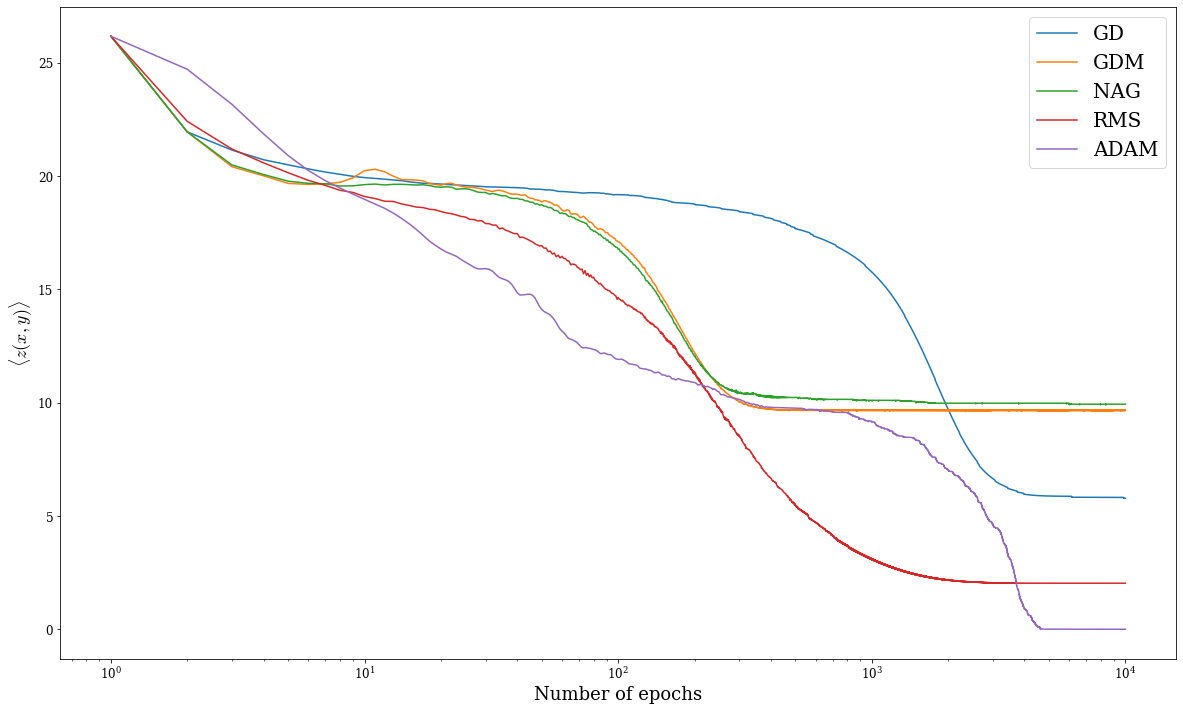

In [29]:
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(np.linspace(1, epoch+1, epoch+1), avg_gd, label='GD')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_gdm, label='GDM')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_NAG, label='NAG')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_rms_prop, label='RMS')
ax.plot(np.linspace(1, epoch+1, epoch+1), avg_adam, label='ADAM')

ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlabel("Number of epochs", size=18)
ax.set_ylabel(r"$\langle z(x,y) \rangle$", size=18)
ax.legend(prop={'size': 20})
plt.show()

In this case ADAM performs better than the other methods and it's the only one actually reaching the minimum. Also, it doesn't oscillate like it did with the previous function and we didn't need to set a specific learning rate for it.<br>
This is due to the fact that ADAM is more sensible to the presence of local minima: in this case we don't have any and so one possible reason for the better performance could be the convexity of the surface.

In the figure below we show some of the paths covered over the surface to qualitatively visualize the various behaviours of different algorithms. Note that the dot is the descent end point.

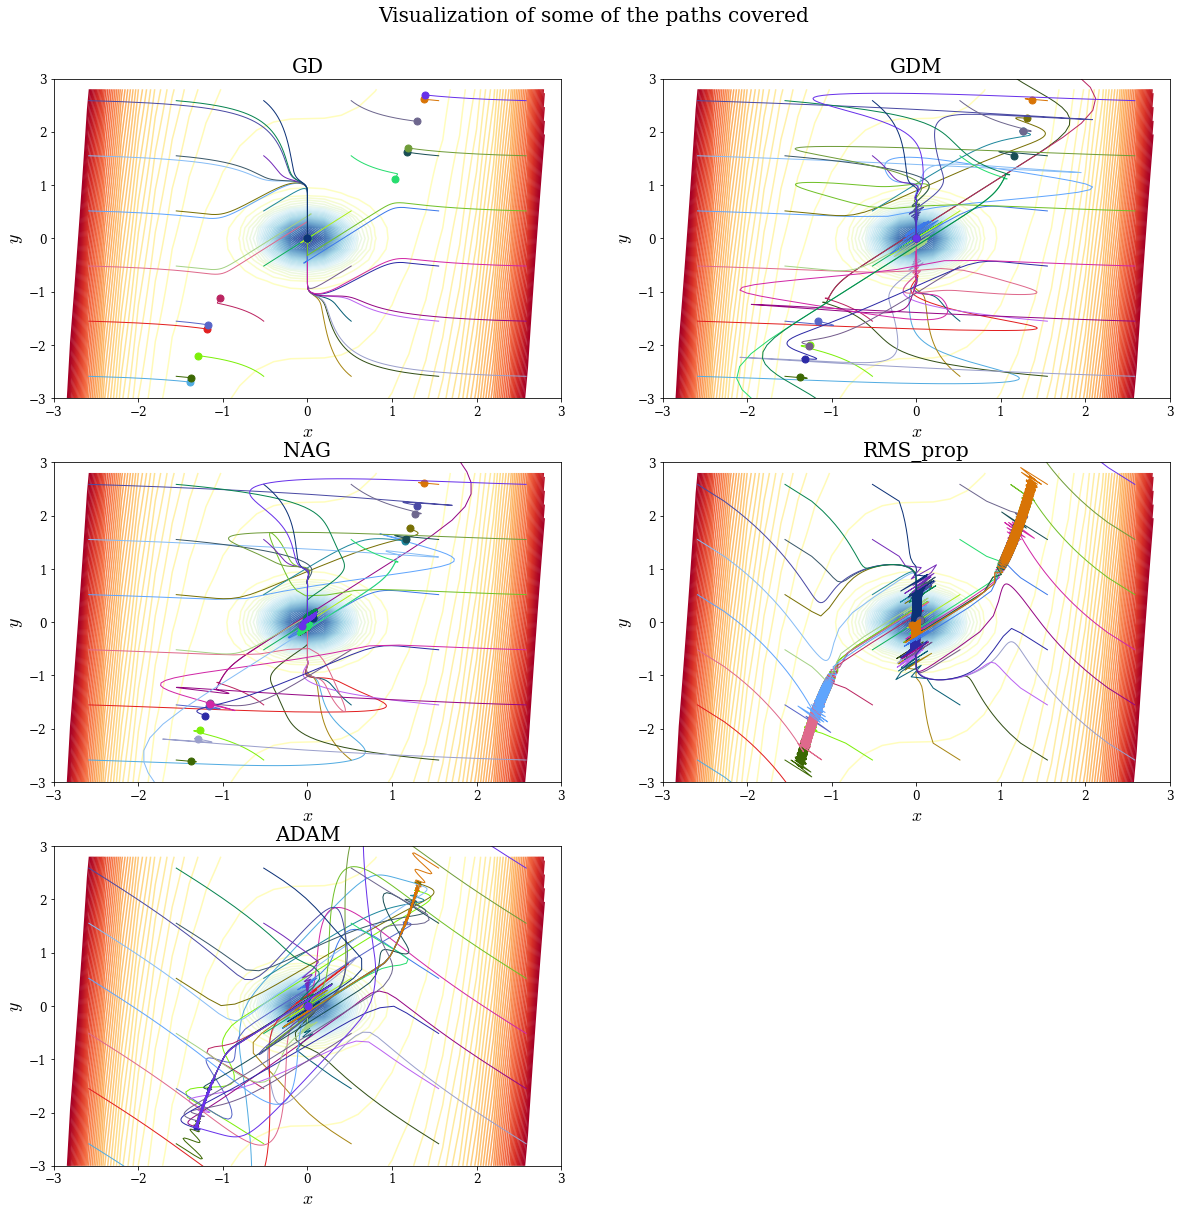

In [30]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Visualization of some of the paths covered', y=0.93, fontsize=20)

ax1, ax2, ax3, ax4, ax5 = 0,0,0,0,0
axes = [ax1, ax2, ax3, ax4, ax5]
labels = ['GD', 'GDM', 'NAG', 'RMS_prop', 'ADAM']
a = 1
for i in range(len(axes)):
    axes[i] = fig.add_subplot(3, 2, a)
    axes[i] = contour_func_1(axes[i])
    axes[i].set_title(labels[i], fontsize=20)
    a+=1

for i in range(n_coord):
    for j in range(n_coord):
        if i % 5 == 2 and j % 5 == 2:
            c = np.random.rand(3)
            overlay_trajectory_contour_M(axes[0],gd_trajectory[:,i*n_coord+j,:], 'GD', color=c)
            overlay_trajectory_contour_M(axes[1],gdm_trajectory[:,i*n_coord+j,:], 'GDM',color=c)
            overlay_trajectory_contour_M(axes[2],NAG_trajectory[:,i*n_coord+j,:], 'NAG',color=c)
            overlay_trajectory_contour_M(axes[3],rms_prop_trajectory[:,i*n_coord+j,:], 'rms',color=c)
            overlay_trajectory_contour_M(axes[4],adam_trajectory[:,i*n_coord+j,:], 'adam',color=c)
        
plt.show()